# Calculate correlation of resting & reading

In [81]:
import pandas as pd
import numpy as np
from numpy import corrcoef
from scipy.signal import butter, lfilter, welch
import matplotlib.pyplot as plt

## Preparation

In [82]:
fs = 250

In [83]:
def high_pass(low, high, df, order=4):
    """
    Filter channel data with butterworth filter
    """
    nyq = 0.5 * fs
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    # filtered dataframe
    fil_df = pd.DataFrame(dtype="float64")
    for i, col in enumerate(df):
        fil_df[df.columns[i]] = lfilter(b, a, df[col])
    
    return fil_df

In [84]:
# try a file
rest_df = pd.read_csv('Data/Resting/R600_RestingState.csv')
read_df = pd.read_csv('Data/Reading/R600_ND.csv')

# filter
high = 40
low = 0.5
fil_rest = high_pass(low, high, rest_df)
fil_read = high_pass(low, high, read_df)

# take one channel
rest_cz = rest_df.Cz
read_cz = read_df.Cz
# clip, start at 1000th data point as there seems to be a noise
# make sure it contains integer number of epochs
start = 750
end = min(len(rest_cz), len(read_cz))
end = end - (end % fs)
read_cz = read_cz[start:end]
rest_cz = rest_cz[start:end]
assert read_cz.shape == rest_cz.shape

## Baseline

In [85]:
def baseline(resting_cz, fs):
    """
    Using resting data to calculate baseline. For now, using channle CZ
    
    params:
        resting_cz: Resting data from CZ with length divisible by 2 * fs
        fs: sampling rate
    
    returns:
        value of the baseline
    """
    assert len(resting_cz) % (2 * fs) == 0
    resting_cz = resting_cz.values.reshape((int(len(resting_cz) / (2 * fs)), 2 * fs))
    # power list to store the power spectrum for each epoch
    freq = []
    powers = []
    for epoch in resting_cz:
        f, power = welch(epoch, nperseg=fs, noverlap=None)
        freq = f
        powers.append(power)
    powers = np.asarray(powers)
    # take the mean of power
    mean_power = np.mean(powers, axis=0)
    assert len(mean_power) == powers.shape[1]
    # get correlations between each epoch power, and mean power
    corrs = []
    for power in powers:
        corrs.append(corrcoef(power, mean_power)[0][1])
    # baseline is the mean of correlations
    return np.mean(corrs)

In [86]:
b = baseline(rest_cz, fs)

## reading comparison to baseline

In [87]:
def correlation_rest_read(resting_cz, reading_cz, fs):
    """
    Calculate correlation between resting and reading data. For now, using channel CZ
    
    params:
        resting_cz: Resting data from CZ with length divisible by 2 * fs
        reading_cz: Reading data from CZ with length same as resting
        fs: sampling rate
    
    returns:
        a list of correlation values between reading and resting
    """
    assert len(resting_cz) % (2 * fs) == 0 and len(resting_cz) == len(reading_cz)
    resting_cz = resting_cz.values.reshape((int(len(resting_cz) / (2 * fs)), 2 * fs))
    reading_cz = reading_cz.values.reshape((int(len(reading_cz) / (2 * fs)), 2 * fs))
    corrs = []
    for ii, rest_epoch in enumerate(resting_cz):
        _, rest_power = welch(rest_epoch, nperseg=fs, noverlap=None)
        _, read_power = welch(reading_cz[ii], nperseg=fs, noverlap=None)
        corrs.append(corrcoef(rest_power, read_power)[0][1])
    
    return corrs

In [88]:
corrs = correlation_rest_read(rest_cz, read_cz, fs)

## Plot

<Figure size 432x288 with 0 Axes>

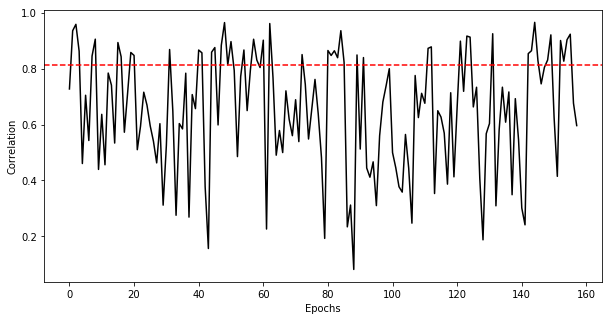

In [89]:
plt.clf()
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 5)
x = np.arange(len(corrs))
ax.plot(x, corrs, "black")
ax.set_xlabel("Epochs")
ax.set_ylabel("Correlation")
ax.axhline(b, color='red', ls='--')